In [2]:
%%capture
try:
    from icevision.all import *
except:
    !pip install -U torch-snippets typer imgaug
    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
    !bash install_colab.sh

In [3]:
# Setup Data
# %%capture
%load_ext autoreload
%autoreload 2

from torch_snippets import *

# If running locally from AutoTrain/nbs
if not os.path.exists('/content') and P().resolve().stem != 'AutoTrain':
    %cd ..

if os.path.exists('/content') and not os.path.exists('/content/AutoTrain'):
    !git clone https://github.com/sizhky/AutoTrain

if not P().resolve().stem == 'AutoTrain':
    %cd AutoTrain

!git pull origin V1
!git checkout V1

if not os.path.exists('open-images-bus-trucks.tar.xz'):
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz -O open-images-bus-trucks.tar.xz
    unzip_file('open-images-bus-trucks.tar.xz', './')
    P('open-images-bus-trucks').mv('data')
    makedir('open-images-bus-trucks')
    P('data').mv('open-images-bus-trucks/data')
    

/mnt/d04d289c-d0a7-4fd4-b883-ff227b3a8695/githubs/AutoTrain
fatal: couldn't find remote ref V1
M	auto_train_object_detection/train.py
M	auto_train_segmentation/train.py
M	config.ini
D	nbs/1_setup_training_images.ipynb
Already on 'V1'


In [9]:
!cat config.ini

[project]
owner: sizhky
name: my_segmentation_project
location: ${project.name}
model_directory: ${project.location}/models
type: object_detection
num_classes: 2
auto_train_lib: auto_train_${project.type}
classes: []

[label_studio]
base_data_dir: /tmp/data/

[label_studio_ml]
app_name: ${project.name}/my_ml_model
script_path: ${project.auto_train_lib}/script.py

[online_training]
save_dir: ${project.model_directory}/model.pt

[architecture]
model_type: ultralytics.yolov5
backbone: small
pretrained: True
size: 384
[architecture.extra_args]
img_size: ${architecture.size}

[training]
dir: /content/drive/MyDrive/dental-template-kunal/train-data-sample/
images_dir: ${training.dir}/images
annotations_dir: ${training.dir}/annotations
train_ratio: 0.8
[training.preprocess]
@augmentations: get_train_transforms
size: ${architecture.size}
presize: 512

[training.data]
train_dir: ${training.dir}/train
validation_dir: ${training.dir}/validation

[training.scheme]
epochs: 20
lr: 1e-4
freeze_epochs:

In [10]:
!python auto_train_object_detection/train.py find-best-learning-rate

INFO     - 15225 files found at open-images-bus-trucks/data/images | torch_snippets.paths:inner:24
15225 images found
WARNING  - This function will be deprecated, instantiate the concrete classes instead: `COCOBBoxParser`, `COCOMaskParser`, `COCOKeypointsParser` | icevision.parsers.coco_parser:coco:24
INFO     - 
CLASSES INFERRED FROM open-images-bus-trucks/data/annotations/mini_open_images_train_coco_format.json: <ClassMap: {'background': 0, 'Bus': 1, 'Truck': 2}> | __main__:<module>:17
100%|███████████████████████████████████████| 612/612 [00:00<00:00, 1312.62it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|████████████████████████████████████████| 82/82 [00:00<00:00, 17770.64it/s]
Traceback (most recent call last): 57.32% [47/82 00:03<00:02 0.2583]
  File "auto_train_object_detection/train.py", line 92, in <module>
    app()
  File "/home/yyr/anaconda3/lib/python3.7/site-packages/typer/main.py", line 214, in __call__
    return get_command(self)(*args, *

In [15]:
!python auto_train_object_detection/train.py train-model --lr 7e-4

INFO     - 15225 files found at open-images-bus-trucks/data/images | torch_snippets.paths:inner:24
15225 images found
WARNING  - This function will be deprecated, instantiate the concrete classes instead: `COCOBBoxParser`, `COCOMaskParser`, `COCOKeypointsParser` | icevision.parsers.coco_parser:coco:24
INFO     - 
CLASSES INFERRED FROM open-images-bus-trucks/data/annotations/mini_open_images_train_coco_format.json: <ClassMap: {'background': 0, 'Bus': 1, 'Truck': 2}> | __main__:<module>:17
100%|███████████████████████████████████████| 612/612 [00:00<00:00, 3256.25it/s]
INFO     - Autofixing records | icevision.parsers.parser:parse:136
100%|████████████████████████████████████████| 82/82 [00:00<00:00, 19424.65it/s]
INFO     - Loaded weights from open-images-bus-trucks/models/model.pt to given model | __main__:train_model:74
[0, 0.21080046892166138, 0.23905956745147705, 0.11094465475987805, '00:06']
[1, 0.2082098126411438, 0.22712354362010956, 0.16362031840518845, '00:05']
[2, 0.1927021592

In [16]:
from torch_snippets import *
from icevision.all import *
from auto_train_object_detection.custom_functions import *
from torch_snippets.registry import registry, Config, AttrDict

config = Config().from_disk('config.ini')
config = AttrDict(registry.resolve(config))

image_size = config.architecture.size
class_map = ClassMap(config.project.classes)

assert config.architecture.model_type.count('.', 1), "Architecture should look like <base>.<model>"
extra_args = config.architecture.extra_args
a, b = config.architecture.model_type.split('.')
model_type = getattr(getattr(models, a), b)
backbone = getattr(model_type.backbones, config.architecture.backbone)(config.architecture.pretrained)
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map), **extra_args)

from torch_snippets import load_torch_model_weights_to, save_torch_model_weights_from, makedir
yolo_path = config.training.scheme.output_path
load_torch_model_weights_to(model, yolo_path)


INFO     - Loaded weights from open-images-bus-trucks/models/model.pt to given model | __main__:<module>:21


In [19]:
folder = 'open-images-bus-trucks/data/images/'
fpaths = []
image_extns = ['png','jpg','jpeg']
for extn in image_extns:
    fpaths += P(folder).Glob(f'*.{extn}')
imgs = [read(f, 1) for f in choose(fpaths, 4)]
logger.info(f'Found {len(imgs)} images')

infer_tfms = tfms.A.Adapter([
    *tfms.A.resize_and_pad(size=512),
    tfms.A.Normalize()
])

infer_ds = Dataset.from_images(imgs, infer_tfms, class_map=class_map)
infer_dl = model_type.infer_dl(infer_ds, batch_size=1)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

INFO     - Found 4 images | __main__:<module>:7


  0%|          | 0/4 [00:00<?, ?it/s]

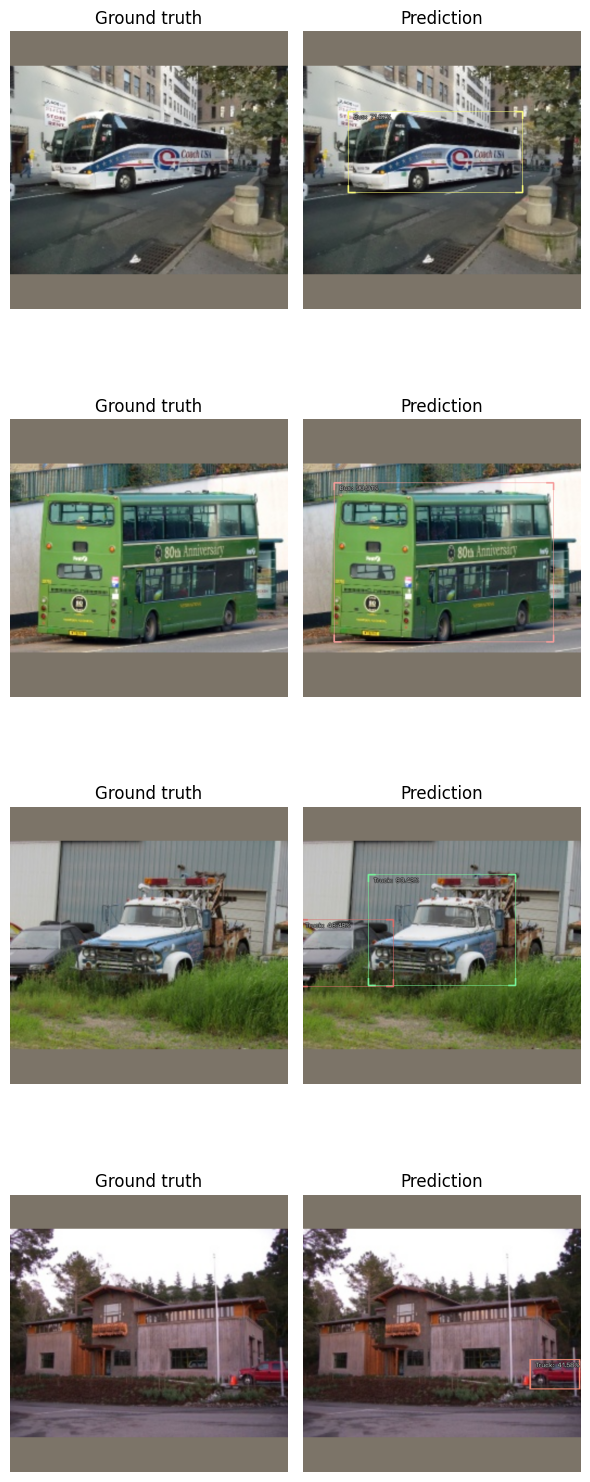

In [20]:
show_preds(preds=preds, ncols=3)